The notebook is used to create the visualizations of the similarity between labels generated from Amazon Rekognition and the Vizwiz groundtruth captions, with the first 25 images using  

Method 1. TF-IDF representation and cosine similarity.  
Method 2. BoW representation and Jaccard similarity.  

In [ ]:
import pandas as pd
import numpy as np
import statistics
import os
import json
import zipfile

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt') # for tokenization
nltk.download('stopwords') # for removing stopword
nltk.download('wordnet') # for lemmatization
stop_words = set(stopwords.words('english'))

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download image-labels data AWS Rekognition processed on validation images.  

In [ ]:
file_path = '/content/drive/My Drive/Capstone Project/rekognition_val_outputs.csv'
aws_df=pd.read_csv(file_path)

In [ ]:
aws_df = aws_df.head(25)

In [ ]:
aws_df.shape

(25, 2)

In [ ]:
aws_df = aws_df.rename(columns={"tokens":"Labels"})

In [ ]:
aws_df.head()

,image_id,Labels
0,0,"['Computer', 'Electronics', 'Laptop', 'Pc', 'Screen', 'Computer Hardware', 'Hardware', 'Monitor']"
1,1,"['Food', 'Seasoning', 'Syrup']"
2,2,"['Publication', 'Book', 'Text', 'Animal', 'Canine', 'Dog', 'Mammal', 'Pet']"
3,3,['Toothpaste']
4,4,"['Electronics', 'Screen', 'Computer Hardware', 'Hardware', 'Monitor', 'TV']"


Preprocess aws labels

In [ ]:
def preprocess_text(text):
    # lowercase
    text = text.lower()

    # tokenize text
    tokens = word_tokenize(text)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    no_stopwords_tokens = [word for word in tokens if word not in stop_words]

    # lemmatize text
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in no_stopwords_tokens]

    text = ' '.join(lemmatized_tokens)

    return text

In [ ]:
# apply text preprocessing
aws_df['preprocessed_text'] = aws_df['Labels'].apply(preprocess_text)

aws_df.head()

,image_id,Labels,preprocessed_text
0,0,"['Computer', 'Electronics', 'Laptop', 'Pc', 'Screen', 'Computer Hardware', 'Hardware', 'Monitor']","[ 'computer ' , 'electronics ' , 'laptop ' , 'pc ' , 'screen ' , 'computer hardware ' , 'hardware ' , 'monitor ' ]"
1,1,"['Food', 'Seasoning', 'Syrup']","[ 'food ' , 'seasoning ' , 'syrup ' ]"
2,2,"['Publication', 'Book', 'Text', 'Animal', 'Canine', 'Dog', 'Mammal', 'Pet']","[ 'publication ' , 'book ' , 'text ' , 'animal ' , 'canine ' , 'dog ' , 'mammal ' , 'pet ' ]"
3,3,['Toothpaste'],[ 'toothpaste ' ]
4,4,"['Electronics', 'Screen', 'Computer Hardware', 'Hardware', 'Monitor', 'TV']","[ 'electronics ' , 'screen ' , 'computer hardware ' , 'hardware ' , 'monitor ' , 'tv ' ]"


Load validation data from VizWiz

In [ ]:
#extract annotations (val.json, train.json, test.json)
zip_files = ['/content/drive/MyDrive/Capstone Project/annotations.zip']

#destination folder for extracted files
destination_folder = '/content/'

#create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

#loop through each zip file
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        #extract the contents of the zip file to the destination folder
        zip_ref.extractall(destination_folder)

In [ ]:
with open('annotations/val.json', 'r') as f:
    annotation_data = json.load(f)

annotation_data.keys()

dict_keys(['info', 'images', 'annotations'])

In [ ]:
len(annotation_data['images'])

7750

In [ ]:
annotation_data['annotations'][:2]

[{'caption': 'A computer screen shows a repair prompt on the screen.',
  'image_id': 23431,
  'is_precanned': False,
  'is_rejected': False,
  'id': 117155,
  'text_detected': True},
 {'caption': 'a computer screen with a repair automatically pop up',
  'image_id': 23431,
  'is_precanned': False,
  'is_rejected': False,
  'id': 117156,
  'text_detected': True}]

In [ ]:
caption_list = []
id_list = []
for captions in annotation_data['annotations']:
    caption_list.append(captions['caption'])
    id_list.append(captions['image_id'])

In [ ]:
viz_df = pd.DataFrame(data={'caption': caption_list, 'image_id': id_list})

In [ ]:
viz_df = viz_df.head(125)

In [ ]:
# adjust image id and image name
viz_df['image_id'] = viz_df['image_id'] - 23431

In [ ]:
viz_df.head(10)

,caption,image_id
0,A computer screen shows a repair prompt on the screen.,0
1,a computer screen with a repair automatically pop up,0
2,partial computer screen showing the need of repairs,0
3,Part of a computer monitor showing a computer repair message.,0
4,The top of a laptop with a blue background and dark blue text.,0
5,A person is holding a bottle that has medicine for the night time.,1
6,A bottle of medication has a white twist top.,1
7,night time medication bottle being held by someone,1
8,a person holding a small black bottle of NIGHT TIME,1
9,A bottle of what appears to be cough syrup held in hand.,1


In [ ]:
# for each image, combine the five captions into a single list
viz_combined = viz_df.groupby('image_id')['caption'].apply(' '.join).reset_index()

viz_combined.rename(columns={'caption': 'combined_captions'}, inplace=True)

In [ ]:
# apply preprocessing
viz_combined['preprocessed_text'] = viz_combined['combined_captions'].apply(preprocess_text)

In [ ]:
viz_combined.head()

,image_id,combined_captions,preprocessed_text
0,0,A computer screen shows a repair prompt on the screen. a computer screen with a repair automatically pop up partial computer screen showing the need of repairs Part of a computer monitor showing a computer repair message. The top of a laptop with a blue background and dark blue text.,computer screen show repair prompt screen . computer screen repair automatically pop partial computer screen showing need repair part computer monitor showing computer repair message . top laptop blue background dark blue text .
1,1,A person is holding a bottle that has medicine for the night time. A bottle of medication has a white twist top. night time medication bottle being held by someone a person holding a small black bottle of NIGHT TIME A bottle of what appears to be cough syrup held in hand.,person holding bottle medicine night time . bottle medication white twist top . night time medication bottle held someone person holding small black bottle night time bottle appears cough syrup held hand .
2,2,"a white paper showing an image of black and brown dog A library book with pictures of two dogs on the cover on a wooden table. A book with a black and a tan dog walking down a snowy street. The book cover shows two dogs in the snow A book cover title Dog Years with an image of a black and brown dog walking up the street, on the left side it has a due date sticker from a library.","white paper showing image black brown dog library book picture two dog cover wooden table . book black tan dog walking snowy street . book cover show two dog snow book cover title dog year image black brown dog walking street , left side due date sticker library ."
3,3,"A white box is to the left of a blue box on a wooden table. A small rectangular red and white box next to a small rectangular blue box on a wooden surface. two boxes of medicine, one white and red and the other blue sitting on a table Two boxes that appear to contain medication or eye drops Two boxes of pharmaceutical products left in a table","white box left blue box wooden table . small rectangular red white box next small rectangular blue box wooden surface . two box medicine , one white red blue sitting table two box appear contain medication eye drop two box pharmaceutical product left table"
4,4,close up of a computer monitor that is powered on. A monitor has a message displayed on it. Pictured here is a screenshot that shows an error message from an app. Computer screen displaying an error saying the display driver is not supported by Zoom Text. a screenshot of someone's monitor that is having issues,close computer monitor powered . monitor message displayed . pictured screenshot show error message app . computer screen displaying error saying display driver supported zoom text . screenshot someone 's monitor issue


## Method 1: TF-IDF representation & Cosine similarity

If using direct creation of TF-IDF representation for preprocessed_text column in both aws_df and viz_combined dataframes, we can see from the shape that the dimensions of two tf-idf representations are different. Need to train with combined vocabulary in order to compute cosine similarity. If not, it arises incompatible dimension value error.

In [ ]:
def create_full_voc_tfidf(dataframe1, dataframe2, column1, column2):

  full_voc = dataframe1[column1].to_list() + dataframe2[column2].to_list()

  tfidf_vectorizer = TfidfVectorizer()
  tfidf_vectorizer.fit(full_voc)

  tfidf_matrix_1 = tfidf_vectorizer.transform(dataframe1[column1])
  tfidf_matrix_2 = tfidf_vectorizer.transform(dataframe2[column2])

  tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()


  return tfidf_matrix_1, tfidf_matrix_2, tfidf_feature_names


In [ ]:
tfidf_full_aws, tfidf_full_viz_combined, tfidf_full_feature = create_full_voc_tfidf(aws_df, viz_combined, 'preprocessed_text','preprocessed_text')

In [ ]:
print("Shape of TF-IDF Representation (DataFrame aws_df):", tfidf_full_aws.toarray().shape)

print("Shape of TF-IDF Representation (DataFrame viz_combined):", tfidf_full_viz_combined.toarray().shape)

print("Full TF-IDF Feature Names from both dataframes:", tfidf_full_feature)

Shape of TF-IDF Representation (DataFrame aws_df): (25, 380)
Shape of TF-IDF Representation (DataFrame viz_combined): (25, 380)
Full TF-IDF Feature Names from both dataframes: ['1545' '64' 'adapter' 'advertisement' 'animal' 'app' 'appear' 'appears'
 'approximately' 'architecture' 'around' 'association' 'attached'
 'automatically' 'automobile' 'baby' 'back' 'background' 'bar' 'barcode'
 'behind' 'beside' 'big' 'billboard' 'bit' 'black' 'blinding' 'blue'
 'blurry' 'book' 'bottle' 'box' 'boy' 'brand' 'brick' 'bright' 'brown'
 'building' 'bunch' 'bus' 'cable' 'calculator' 'camera' 'canine' 'card'
 'case' 'cd' 'ceiling' 'checked' 'child' 'city' 'clean' 'close' 'clothing'
 'cloud' 'code' 'colored' 'commodity' 'computer' 'condo' 'conifer'
 'contain' 'containing' 'contains' 'content' 'corner' 'cough' 'counter'
 'couple' 'court' 'cover' 'cross' 'currently' 'curving' 'cutlery' 'dark'
 'date' 'decorates' 'delete' 'deli' 'dell' 'desk' 'desktop' 'device'
 'dialog' 'dialogue' 'diaper' 'dictionary' '

Compute Cosine Similarity Scores for corresponding images

In [ ]:
# compute cosine similarity (the result is between each pair of images)
cosine_sim_matrix = cosine_similarity(tfidf_full_aws, tfidf_full_viz_combined)

# to get similarity scores for corresponding images, need to extract diagonal elements
corresponding_cosine_sim_scores = cosine_sim_matrix.diagonal()

In [ ]:
cosine_sim_dict={}
for index, score in enumerate(corresponding_cosine_sim_scores):
  cosine_sim_dict[index] = score
  print(f"Cosine similarity between AWS Rekognition and VizWiz Groundtruth of image {index} is: {score:.3f}")

Cosine similarity between AWS Rekognition and VizWiz Groundtruth of image 0 is: 0.332
Cosine similarity between AWS Rekognition and VizWiz Groundtruth of image 1 is: 0.072
Cosine similarity between AWS Rekognition and VizWiz Groundtruth of image 2 is: 0.327
Cosine similarity between AWS Rekognition and VizWiz Groundtruth of image 3 is: 0.000
Cosine similarity between AWS Rekognition and VizWiz Groundtruth of image 4 is: 0.191
Cosine similarity between AWS Rekognition and VizWiz Groundtruth of image 5 is: 0.177
Cosine similarity between AWS Rekognition and VizWiz Groundtruth of image 6 is: 0.000
Cosine similarity between AWS Rekognition and VizWiz Groundtruth of image 7 is: 0.000
Cosine similarity between AWS Rekognition and VizWiz Groundtruth of image 8 is: 0.251
Cosine similarity between AWS Rekognition and VizWiz Groundtruth of image 9 is: 0.154
Cosine similarity between AWS Rekognition and VizWiz Groundtruth of image 10 is: 0.298
Cosine similarity between AWS Rekognition and VizWiz 

In [ ]:
print(f"[First 25 images] The cosine similarity score of TF-IDF representation of labels from AWS Rekognition with groundtruth VizWiz captions is {np.average(corresponding_cosine_sim_scores):.3f}")

[First 25 images] The cosine similarity score of TF-IDF representation of labels from AWS Rekognition with groundtruth VizWiz captions is 0.187


## Method 2: BoW representation & Jaccard similarity

For BoW representatoin, same that we should train with the full vocabulary for both to avoid dimension mismatch in similarity computation.

In [ ]:
def create_full_voc_bow(dataframe1, dataframe2, column1, column2):

  full_voc = dataframe1[column1].to_list() + dataframe2[column2].to_list()

  bow_vectorizer = CountVectorizer()
  bow_vectorizer.fit(full_voc)

  bow_matrix_1 = bow_vectorizer.transform(dataframe1[column1])
  bow_matrix_2 = bow_vectorizer.transform(dataframe2[column2])

  bow_feature_names = bow_vectorizer.get_feature_names_out()

  return bow_matrix_1, bow_matrix_2, bow_feature_names

In [ ]:
bow_full_aws, bow_full_viz_combined, bow_full_feature = create_full_voc_bow(aws_df, viz_combined, 'preprocessed_text','preprocessed_text')

In [ ]:
print("Shape of BoW Representation (DataFrame aws_df):", bow_full_aws.toarray().shape)

print("Shape of BoW Representation (DataFrame viz_combined):", bow_full_viz_combined.toarray().shape)

print("Full BoW Feature Names from both dataframes:", bow_full_feature)

Shape of BoW Representation (DataFrame aws_df): (25, 380)
Shape of BoW Representation (DataFrame viz_combined): (25, 380)
Full BoW Feature Names from both dataframes: ['1545' '64' 'adapter' 'advertisement' 'animal' 'app' 'appear' 'appears'
 'approximately' 'architecture' 'around' 'association' 'attached'
 'automatically' 'automobile' 'baby' 'back' 'background' 'bar' 'barcode'
 'behind' 'beside' 'big' 'billboard' 'bit' 'black' 'blinding' 'blue'
 'blurry' 'book' 'bottle' 'box' 'boy' 'brand' 'brick' 'bright' 'brown'
 'building' 'bunch' 'bus' 'cable' 'calculator' 'camera' 'canine' 'card'
 'case' 'cd' 'ceiling' 'checked' 'child' 'city' 'clean' 'close' 'clothing'
 'cloud' 'code' 'colored' 'commodity' 'computer' 'condo' 'conifer'
 'contain' 'containing' 'contains' 'content' 'corner' 'cough' 'counter'
 'couple' 'court' 'cover' 'cross' 'currently' 'curving' 'cutlery' 'dark'
 'date' 'decorates' 'delete' 'deli' 'dell' 'desk' 'desktop' 'device'
 'dialog' 'dialogue' 'diaper' 'dictionary' 'dietary' 

Per documentation (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html)  

'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted':
Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance.

In [ ]:
jaccard_similarities_macro = []
for i in range(bow_full_aws.shape[0]):
  ja_similarity_macro = jaccard_score(bow_full_viz_combined.toarray()[i], bow_full_aws.toarray()[i], average='macro')
  jaccard_similarities_macro.append(ja_similarity_macro)

In [ ]:
jaccard_similarities_macro_dict = {}
for idx, score in enumerate(jaccard_similarities_macro):
  jaccard_similarities_macro_dict[idx] = score

In [45]:
print(f"[First 25 images] The macro Jaccard similarity score of labels from AWS Rekognition with groundtruth VizWiz captions in BoW represeatation is {statistics.mean(jaccard_similarities_macro):.3f}")

[First 25 images] The macro Jaccard similarity score of labels from AWS Rekognition with groundtruth VizWiz captions in BoW represeatation is 0.228


##Create Vizualization

In [ ]:
cosine_sim_dict

{0: 0.3315515148470789,
 1: 0.07249736067432931,
 2: 0.3265353526797371,
 3: 0.0,
 4: 0.19071913350962583,
 5: 0.17712621827734332,
 6: 0.0,
 7: 0.0,
 8: 0.25133866958710216,
 9: 0.1536642921515124,
 10: 0.2976455427355081,
 11: 0.33296027978949244,
 12: 0.060729546140626846,
 13: 0.0,
 14: 0.047426377552193436,
 15: 0.1929044080158091,
 16: 0.0,
 17: 0.2709146819051943,
 18: 0.28693664227107696,
 19: 0.0,
 20: 0.2141148328691117,
 21: 0.4760149266369382,
 22: 0.3877670231885963,
 23: 0.29221404105894,
 24: 0.31867539729224015}

In [ ]:
jaccard_similarities_macro_dict

{0: 0.2139549436795995,
 1: 0.205358230160341,
 2: 0.15299823633156967,
 3: 0.18789473684210528,
 4: 0.2485742705570292,
 5: 0.136432350718065,
 6: 0.32456140350877194,
 7: 0.31666666666666665,
 8: 0.23944591029023746,
 9: 0.22559366754617413,
 10: 0.18088922571681193,
 11: 0.2341688654353562,
 12: 0.3215276368310669,
 13: 0.31666666666666665,
 14: 0.3534740545294635,
 15: 0.23087071240105542,
 16: 0.23355263157894737,
 17: 0.1988888888888889,
 18: 0.15517241379310345,
 19: 0.18421052631578946,
 20: 0.22889182058047494,
 21: 0.18835978835978834,
 22: 0.31046613896218117,
 23: 0.15564373897707232,
 24: 0.16180851063829788}

In [ ]:
import matplotlib.pyplot as plt

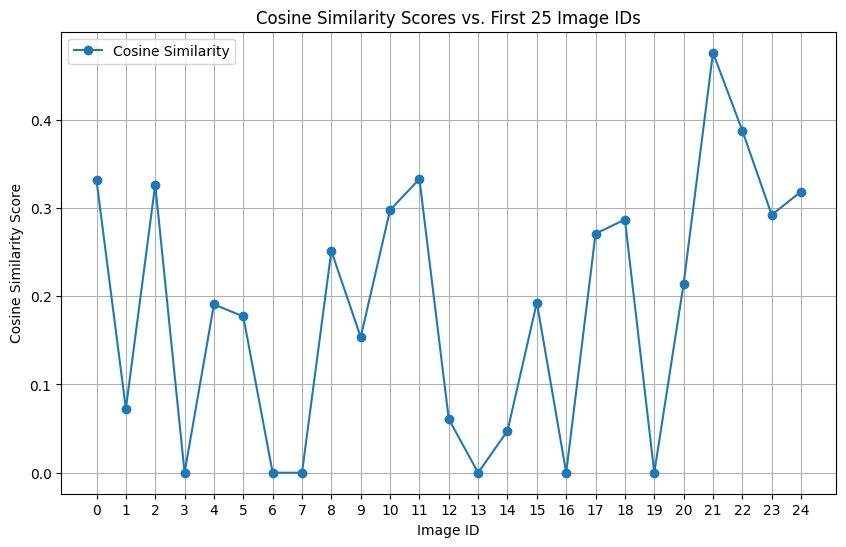

In [ ]:
# x and y values for plotting
cosine_x = list(cosine_sim_dict.keys())
cosine_y = list(cosine_sim_dict.values())

jaccard_x = list(jaccard_similarities_macro_dict.keys())
jaccard_y = list(jaccard_similarities_macro_dict.values())

# create cosine similarity plot
plt.figure(figsize=(10, 6))
plt.plot(cosine_x, cosine_y, label='Cosine Similarity', marker='o')
plt.title('Cosine Similarity Scores vs. First 25 Image IDs')
plt.xlabel('Image ID')
plt.ylabel('Cosine Similarity Score')
plt.xticks(cosine_x)
plt.grid(True)
plt.legend()
plt.show()

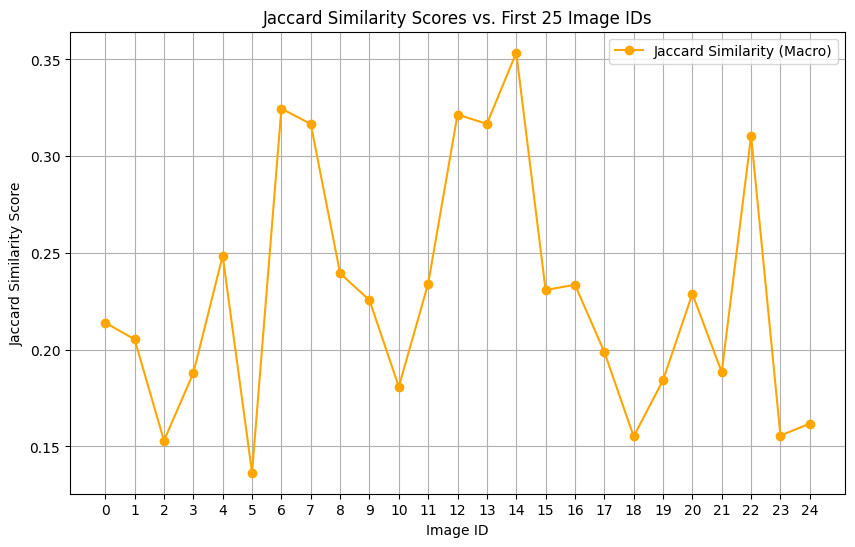

In [ ]:
# create jaccard similarity plot
plt.figure(figsize=(10, 6))
plt.plot(jaccard_x, jaccard_y, label='Jaccard Similarity (Macro)', color='orange', marker='o')
plt.title('Jaccard Similarity Scores vs. First 25 Image IDs')
plt.xlabel('Image ID')
plt.ylabel('Jaccard Similarity Score')
plt.grid(True)
plt.xticks(jaccard_x)
plt.legend()
plt.show()

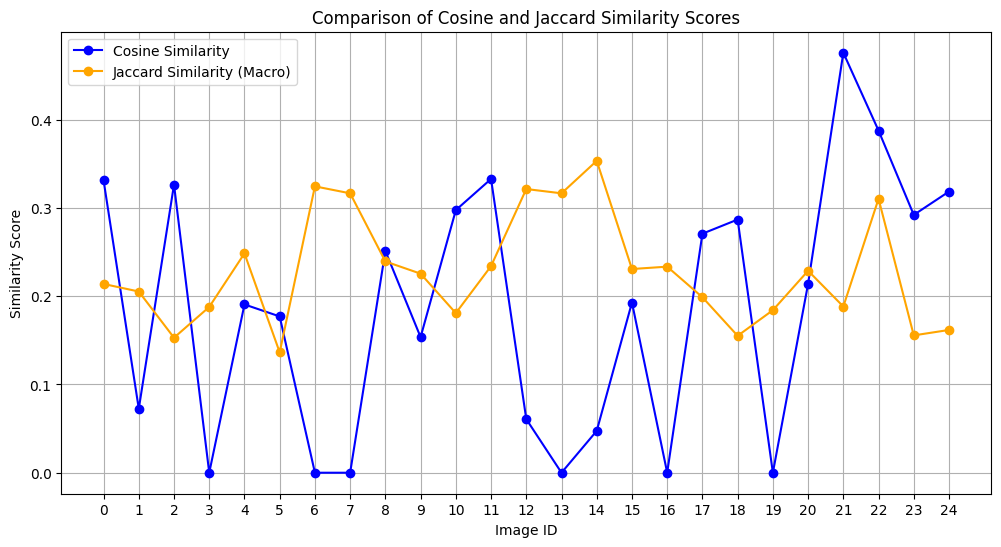

In [ ]:
# create a single plot include both similarity scores
plt.figure(figsize=(12, 6))
plt.plot(cosine_x, cosine_y, label='Cosine Similarity', marker='o', color='blue')
plt.plot(jaccard_x, jaccard_y, label='Jaccard Similarity (Macro)', marker='o', color='orange')
plt.title('Comparison of Cosine and Jaccard Similarity Scores')
plt.xlabel('Image ID')
plt.ylabel('Similarity Score')
plt.xticks(cosine_x)
plt.grid(True)
plt.legend()
plt.show()

In [46]:
aws_df

,image_id,Labels,preprocessed_text
0,0,"['Computer', 'Electronics', 'Laptop', 'Pc', 'Screen', 'Computer Hardware', 'Hardware', 'Monitor']","[ 'computer ' , 'electronics ' , 'laptop ' , 'pc ' , 'screen ' , 'computer hardware ' , 'hardware ' , 'monitor ' ]"
1,1,"['Food', 'Seasoning', 'Syrup']","[ 'food ' , 'seasoning ' , 'syrup ' ]"
2,2,"['Publication', 'Book', 'Text', 'Animal', 'Canine', 'Dog', 'Mammal', 'Pet']","[ 'publication ' , 'book ' , 'text ' , 'animal ' , 'canine ' , 'dog ' , 'mammal ' , 'pet ' ]"
3,3,['Toothpaste'],[ 'toothpaste ' ]
4,4,"['Electronics', 'Screen', 'Computer Hardware', 'Hardware', 'Monitor', 'TV']","[ 'electronics ' , 'screen ' , 'computer hardware ' , 'hardware ' , 'monitor ' , 'tv ' ]"
5,5,"['Electronics', 'Screen', 'Computer Hardware', 'Hardware', 'Monitor', 'Computer', 'Pc']","[ 'electronics ' , 'screen ' , 'computer hardware ' , 'hardware ' , 'monitor ' , 'computer ' , 'pc ' ]"
6,6,"['Flare', 'Light', 'Lighting', 'Sunlight']","[ 'flare ' , 'light ' , 'lighting ' , 'sunlight ' ]"
7,7,[],[ ]
8,8,['Bottle'],[ 'bottle ' ]
9,9,"['Door', 'Handrail']","[ 'door ' , 'handrail ' ]"
